## Problem set 10

**Problem 0** (-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:37:09) 
[Clang 10.0.1 ]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


You will work with the kaggle house price dataset in this problem set and work through a couple of different feature importance metrics. We provide code to train an XGBoost regression model to start you off. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [2]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

(1460, 79)


In [3]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(876, 79)
(292, 79)
(292, 79)


In [4]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [5]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [6]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names(cat_ftrs)) + \
                preprocessor.transformers_[2][-1]

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

(876, 221)
(292, 221)
(292, 221)


In [7]:
# train the XGBoost model
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 23470.132687324658
the test RMSE: 31748.96283078089
the test R2: 0.8540372805542484


**Problem 1** (10 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work through sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

grading suggestion:
- 5 points for correctly calculating the perturbed values
- 5 points for the figure.
    - the figure shouldn't show all the features because then it is too clattered, so it should only show the top 5-10
    - axes must be labelled, legend if necessary, features ordered with respect to their importance

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pylab as plt

result = permutation_importance(XGB, df_test, y_test, n_repeats=10,random_state=0,scoring='neg_root_mean_squared_error')

scores = result.importances
ftr_names = df_test.columns
test_score = np.sqrt(mean_squared_error(y_test,y_test_pred))

No handles with labels found to put in legend.


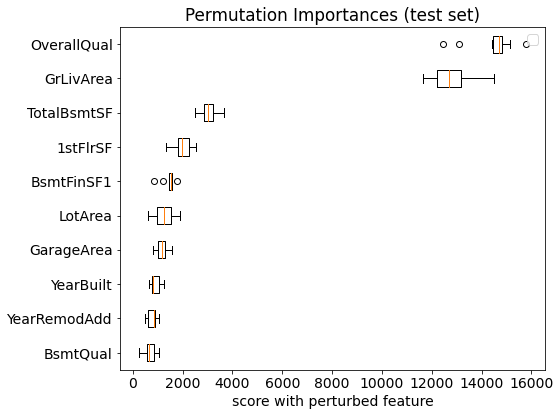

In [9]:
nr_ftrs = 10

sorted_indcs = np.argsort(np.mean(scores,axis=1))
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs[-nr_ftrs:]].T,labels=ftr_names[sorted_indcs[-nr_ftrs:]],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

**Problem 2** (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 publication-ready figures showing the top 10 most important features for each metric.

Grading suggestion
- 5 points for correctly calculating the feature importances and for ordering them
- 5 points for nice figures with labels, titles, correct values

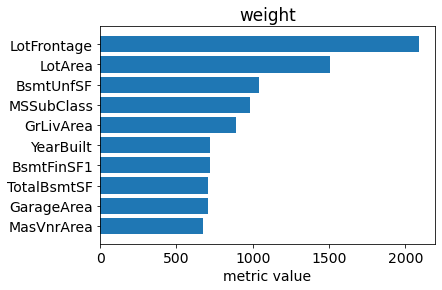

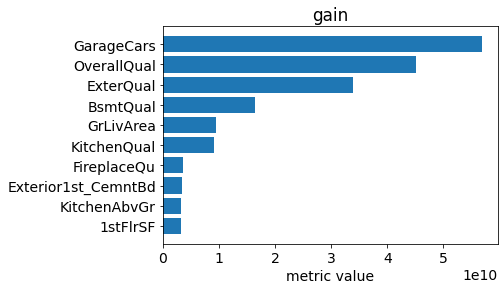

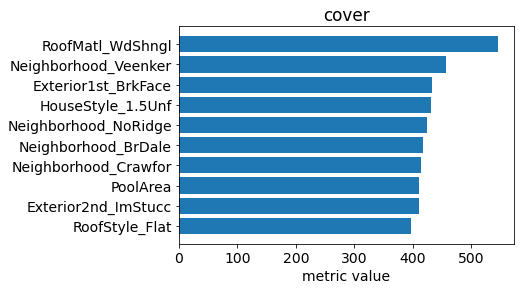

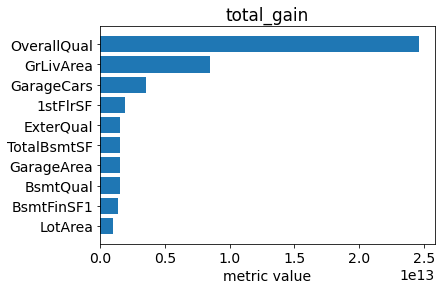

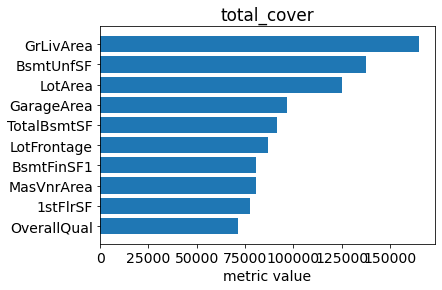

In [10]:
metrics = ['weight','gain','cover','total_gain','total_cover']

for metric in metrics:
    scores = XGB.get_booster().get_score(importance_type=metric)
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
    
    plt.barh(list(scores.keys())[-10:], list(scores.values())[-10:], align='center')
    plt.title(metric)
    plt.xlabel('metric value')
    plt.show()
    

**Problem 3a** (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on piazza. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

In [11]:
import shap
# https://stackoverflow.com/questions/61928198/getting-unicodedecodeerror-when-using-shap-on-xgboost
booster = XGB.get_booster() 
model_bytearray = booster.save_raw()[4:]
booster.save_raw = lambda : model_bytearray

shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(booster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


(292, 221)


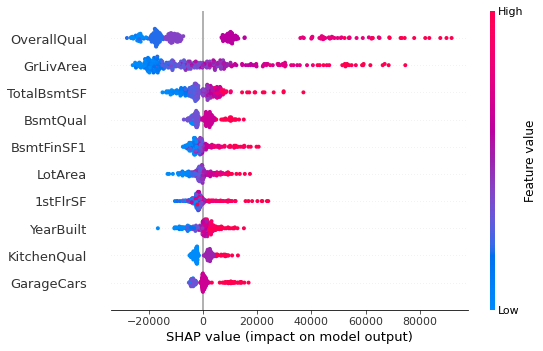

In [12]:
# calculate shap values 
shap_values = explainer.shap_values(df_test)
print(np.shape(shap_values))

shap.summary_plot(shap_values, df_test,feature_names = feature_names,max_display=10)

**Problem 3b** (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

In [13]:
indices = [0, 100, 200]
index=0
print(explainer.expected_value) # the mean
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

181131.8


In [14]:
index=100
print(explainer.expected_value) # the mean
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

181131.8


In [15]:
index=200
print(explainer.expected_value) # the mean
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

181131.8


**Problem 4** (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranked features are quite different depending on the importance metric used. This is obviously not ideal so I recommend you calculate as many feature importance metrics as you can. Having said that, take a look at the top 3 features of each method and look for similarities. Explain what you found.